# This notebook is for the Fair-Shapely experiment

In [155]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [157]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
# _, processed_uci = load_dataset('uci')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [158]:
processed_german_credit.head(3)

,Age,sex,Credit amount,Duration,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0,-0.745131,-1.236478,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,-1.191404,1,0.949817,2.248194,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1.183312,0,-0.416562,-0.738668,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [159]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (700, 26)
X_test shape: (300, 26)


### 4. Train the original model

In [160]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6766666666666666


In [161]:
X_train['sex'].value_counts()

sex
0    479
1    221
Name: count, dtype: int64

In [162]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [163]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_DR: {original_DR}')

original_DR: 0.05330166965723038


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

总共可以替换的点数:374


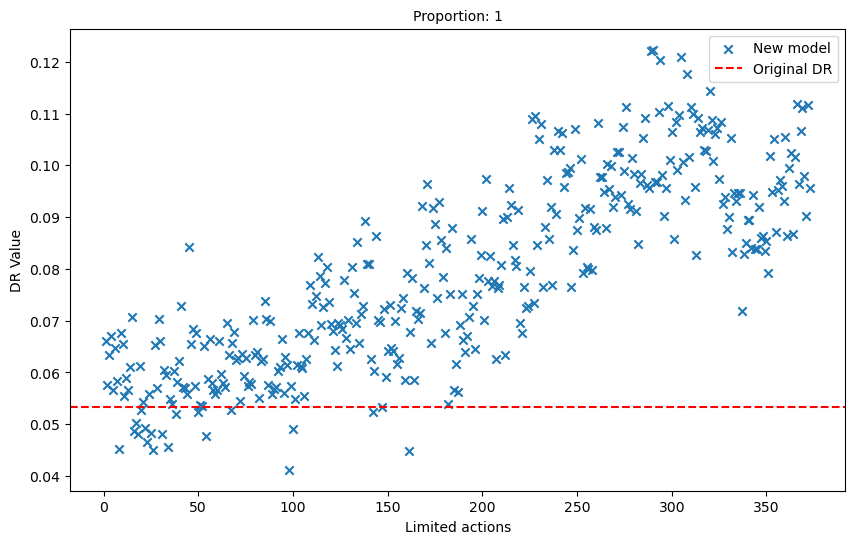

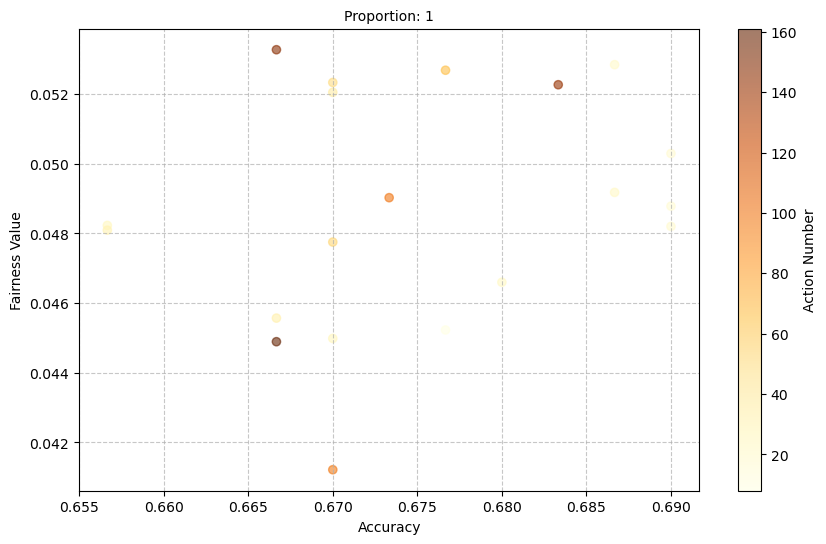

([0.06609437,
  0.057557996,
  0.06332363,
  0.06699586,
  0.056705195,
  0.06471713,
  0.05825531,
  0.045229364,
  0.06761157,
  0.065450214,
  0.055395305,
  0.058836263,
  0.05653483,
  0.060993984,
  0.07066566,
  0.04878304,
  0.05029482,
  0.04820184,
  0.061247636,
  0.052845065,
  0.05435921,
  0.049178638,
  0.04659928,
  0.05582302,
  0.04823103,
  0.044986784,
  0.06527179,
  0.05704001,
  0.07035769,
  0.066062905,
  0.048094068,
  0.060443796,
  0.059515852,
  0.04556998,
  0.054827295,
  0.053986188,
  0.0603346,
  0.052050825,
  0.05825328,
  0.062270686,
  0.07280278,
  0.05720913,
  0.056928903,
  0.055928186,
  0.08422984,
  0.0655546,
  0.068341844,
  0.057306018,
  0.06760088,
  0.052334066,
  0.053642046,
  0.05358714,
  0.06515451,
  0.047753263,
  0.05865244,
  0.06649956,
  0.05805849,
  0.056635782,
  0.055928394,
  0.05668317,
  0.06612368,
  0.059715282,
  0.057898406,
  0.05723765,
  0.06954317,
  0.06336991,
  0.05268512,
  0.06565064,
  0.06787031,
  0.06

In [164]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            change_group = 'minority')
experiment.run_experiment()


总共可以替换的点数:868


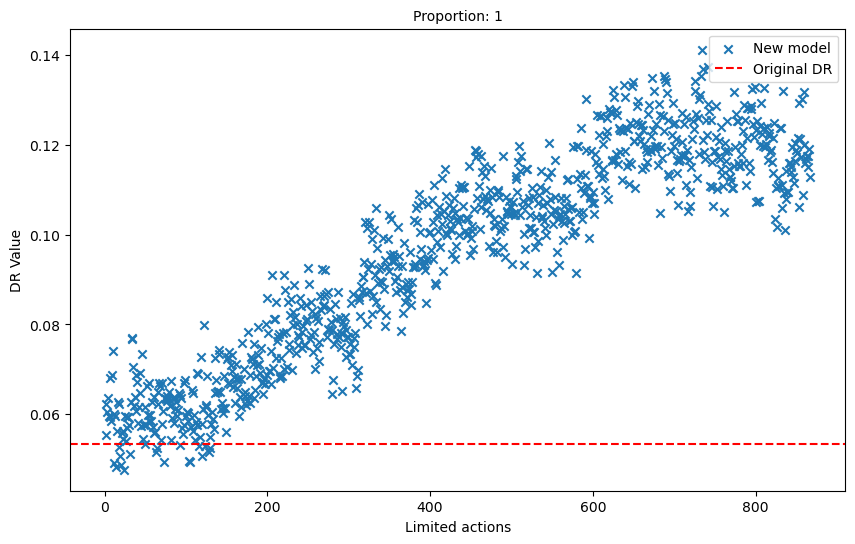

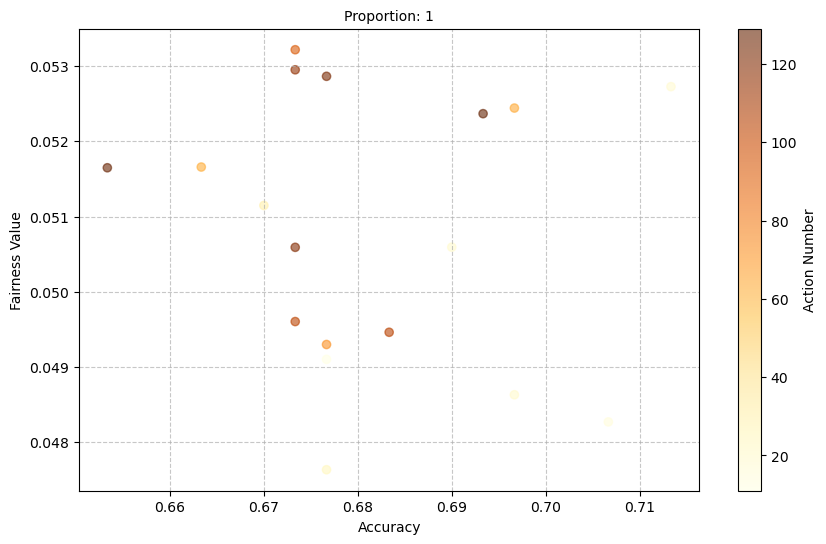

([0.062386133,
  0.055370133,
  0.06043335,
  0.063690186,
  0.05962443,
  0.06806935,
  0.05936311,
  0.05841357,
  0.06871455,
  0.07408281,
  0.04910325,
  0.060003206,
  0.059620857,
  0.048272017,
  0.0561669,
  0.06269184,
  0.062303793,
  0.052727368,
  0.050594132,
  0.048632614,
  0.055720102,
  0.05631201,
  0.05446013,
  0.047636405,
  0.059625182,
  0.05395541,
  0.056834754,
  0.05942641,
  0.059447836,
  0.05752983,
  0.05114839,
  0.062784635,
  0.07692546,
  0.07670416,
  0.07041395,
  0.061816443,
  0.06383409,
  0.060749736,
  0.0688223,
  0.06722698,
  0.05806268,
  0.06153389,
  0.069129795,
  0.06463909,
  0.05734954,
  0.07346845,
  0.05441555,
  0.05763143,
  0.053347703,
  0.06167133,
  0.057632264,
  0.06617909,
  0.05990012,
  0.05841625,
  0.06693498,
  0.059836898,
  0.058509033,
  0.0627216,
  0.057064477,
  0.055753008,
  0.063945085,
  0.056040343,
  0.05165908,
  0.0524429,
  0.06498786,
  0.0623687,
  0.066919066,
  0.06639426,
  0.054262828,
  0.057770

In [166]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            change_group = 'majority')
experiment2.run_experiment()

In [ ]:
''' Experiment new

1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority
2. 将X_train_minority与X_train_replace_majority进行匹配
3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点
4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new
5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值

----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------
'''